In [1]:
%load_ext autoreload
%autoreload 2

# from lib_dpe import *
# import lib_nn as nn
%config InlineBackend.figure_formats = ['svg']
from lib_nn_dpe import NN_dpe

import matplotlib.pyplot as plt
import numpy as np
from lib_data import *
import time
from IPython import display

In [3]:
load_workspace(vars(), 'data/20190815-132601-weights')
load_workspace(vars(), 'data/mnist')

Loaded: weights, 
Loaded: train_images, train_labels, test_images, test_labels, 


In [4]:
nn = NN_dpe(weights)

In [5]:
acc = []

i = 0

for label, img in zip(test_labels, test_images):
    y = nn.forward_pass(img)
    
    acc.append( y.argmax() == label)

    if (i+1)%100 == 0:
        display.clear_output(wait=True)
        print(f'i={i}, accuracy={np.mean(acc) * 100:.4f}%')
    i += 1
    

i=9999, accuracy=98.1500%


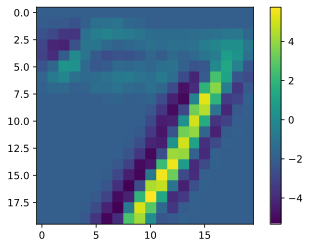

In [7]:
N_BIT = 8
image = test_images[0]

vectors = nn._conv_flattern(image)

vec_int = np.round(vectors* (2**N_BIT -1))
vec_int = np.array(vec_int, dtype=np.uint32)

vec_list = []

for i in range(N_BIT):
    vec_list.append( (vec_int>>i) & 0x1 )

out_list = []

for i in range(N_BIT):
    out = nn.Gconv.T @ vec_list[i]
    out_list.append( out[::2] - out[1::2] )

result = np.zeros( out_list[0].shape )
for i in range(N_BIT):
    result += out_list[i] * (0x1<<i)

result = result / nn.Gratio / (2**N_BIT -1)
    
x = result.T.reshape(20,20,-1)
plt.imshow(x[:,:,1])
plt.colorbar()

In [12]:
x1 = nn.relu(x)
x1 = nn.max_pooling(x1)
x1 = nn.flattern(x1)
y = nn.dense(x1)

print(y.argmax())

7
